The **PCA** object is very useful, but has certain limitations for large datasets. The biggest limitation is that **PCA** only supports batch processing, which means all of the data to be processed must fit in main memory. The **IncrementalPCA** object uses a different form of processing and allows for partial computations which almost exactly match the results of **PCA** while processing the data in a minibatch fashion. **IncrementalPCA** makes it possible to implement out-of-core Principal Component Analysis either by:

Using its `partial_fit` method on chunks of data fetched sequentially from the local hard drive or a network database.

Calling its fit method on a sparse matrix or a memory mapped file using `numpy.memmap`.

IncrementalPCA only stores estimates of component and noise variances, in order update `explained_variance_ratio_` incrementally. This is why memory usage depends on the number of samples per batch, rather than the number of samples to be processed in the dataset.

As in **PCA, IncrementalPCA** centers but does not scale the input data for each feature before applying the SVD.

more [here](https://scikit-learn.org/stable/modules/decomposition.html#incrementalpca)

incremental principal components analysis (IPCA).

Linear dimensionality reduction using Singular Value Decomposition of the data, keeping only the most significant singular vectors to project the data to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

Depending on the size of the input data, this algorithm can be much more memory efficient than a PCA, and allows sparse input.

This algorithm has constant memory complexity, on the order of `batch_size * n_features`, enabling use of np.memmap files without loading the entire file into memory. For sparse matrices, the input is converted to dense in batches (in order to be able to subtract the mean) which avoids storing the entire dense matrix at any one time.

The computational overhead of each SVD is `O(batch_size * n_features ** 2)`, but only 2 * batch_size samples remain in memory at a time. There will be `n_samples / batch_size` SVD computations to get the principal components, versus 1 large SVD of complexity `O(n_samples * n_features ** 2)` for PCA.

[sklearn.decomposition.IncrementalPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

## Preparing the data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model Incremental PCA

In [8]:
class ModelIncPCA:
    
    def __init__(self, n_components):
        self.n_components=n_components
        
    # spe: squared prediction errors
    def spe (self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)
   
    def train(self, df_train):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        if self.n_components == 0:
            self.m = sklearn.decomposition.IncrementalPCA()
        else:
            self.m = sklearn.decomposition.IncrementalPCA(n_components=self.n_components)
           

        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test-self.mu_train)/self.std_train) 
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

# Training the Data

In [9]:
models = {'IncPCA': ModelIncPCA(0)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [10]:
detection_limits

{'IncPCA': 6.463406621247602e-28}

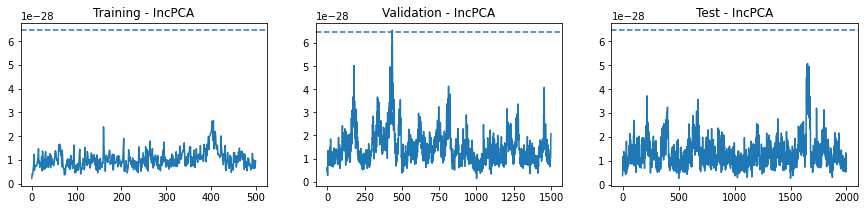

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - IncPCA')
plt.axhline(detection_limits['IncPCA'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - IncPCA')
plt.axhline(detection_limits['IncPCA'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - IncPCA')
plt.axhline(detection_limits['IncPCA'], ls = '--')

# Testing the Data

IncPCA    44.05625
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
IncPCA,98.875,96.875,0.0,0.0,16.125,98.875,43.75,94.5,0.0,1.25,0.25,90.625,86.25,93.25,0.0,1.5,56.875,90.625,0.0,11.5


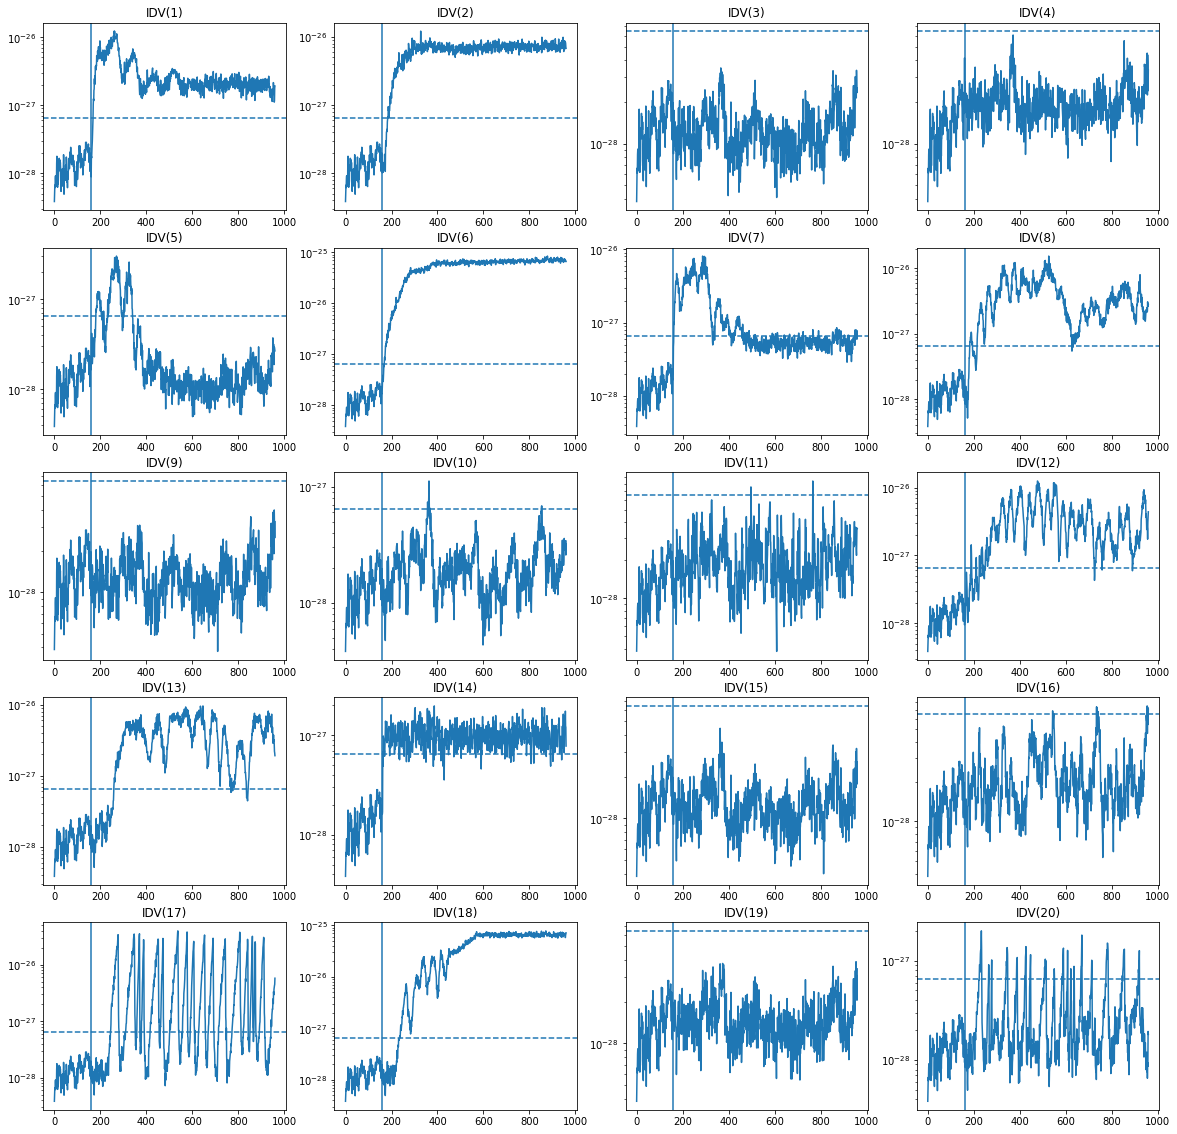

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

In [13]:
spe_test

[array([3.83199432e-29, 5.03450704e-29, 6.65675176e-29, 6.14264884e-29,
        8.37298451e-29, 9.14175178e-29, 7.42718152e-29, 6.94439782e-29,
        6.38195526e-29, 6.48562297e-29, 1.39719525e-28, 1.77116799e-28,
        7.15937494e-29, 7.03017455e-29, 6.21766531e-29, 7.74298377e-29,
        6.94856460e-29, 7.71458353e-29, 1.30010072e-28, 1.12854371e-28,
        1.08517341e-28, 1.65209545e-28, 1.12784191e-28, 1.08943116e-28,
        1.56581698e-28, 1.25860733e-28, 1.43280425e-28, 1.21379664e-28,
        6.24772637e-29, 5.40102979e-29, 9.45448105e-29, 1.12859591e-28,
        1.04161465e-28, 7.19895280e-29, 1.01589483e-28, 1.16059446e-28,
        6.60304359e-29, 6.43962121e-29, 1.11852003e-28, 1.20714689e-28,
        1.86515349e-28, 1.54821274e-28, 4.90832033e-29, 8.45782968e-29,
        1.11138147e-28, 1.15838354e-28, 7.80438833e-29, 8.50298823e-29,
        1.00579144e-28, 1.30481828e-28, 1.06407068e-28, 8.74680464e-29,
        1.72350797e-28, 1.34478217e-28, 7.44340274e-29, 9.967358

In [14]:
fdr

[0.98875,
 0.96875,
 0.0,
 0.0,
 0.16125,
 0.98875,
 0.4375,
 0.945,
 0.0,
 0.0125,
 0.0025,
 0.90625,
 0.8625,
 0.9325,
 0.0,
 0.015,
 0.56875,
 0.90625,
 0.0,
 0.115]

# Training the data with 30 n_components in the model

In [15]:
models = {'IncPCA30': ModelIncPCA(30)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [16]:
detection_limits

{'IncPCA30': 25.84759518707702}

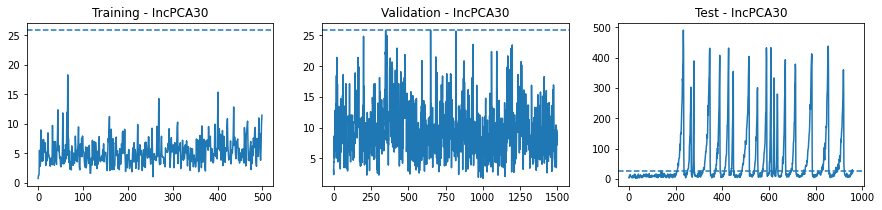

In [17]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - IncPCA30')
plt.axhline(detection_limits['IncPCA30'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - IncPCA30')
plt.axhline(detection_limits['IncPCA30'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - IncPCA30')
plt.axhline(detection_limits['IncPCA30'], ls = '--')

# Testing the new model

IncPCA30    59.10625
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
IncPCA30,99.625,98.0,0.625,84.625,19.125,100.0,99.625,97.625,0.75,13.0,35.5,96.5,90.875,99.75,0.375,24.375,81.25,92.375,3.0,45.125


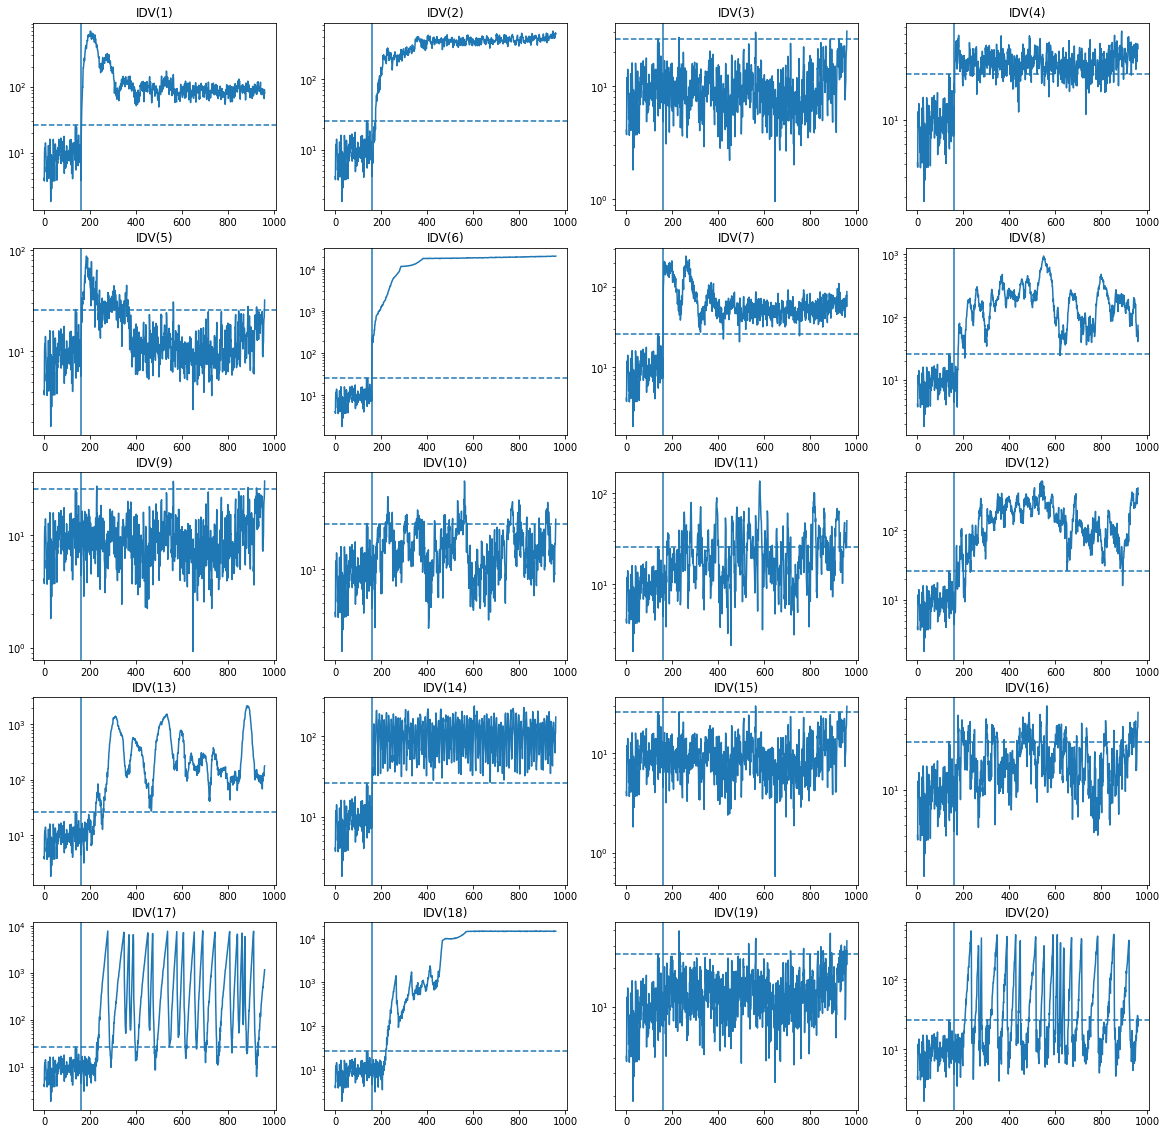

In [18]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

In [19]:
# fdr_df.to_csv('./experimental_result_csv/ipca30.csv')

## Lag variables

In [20]:
def apply_lag (df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged  

## Noise filtering

In [21]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## adding lag variables

incPCA_lag1    59.756250
incPCA_lag2    61.051314
incPCA_lag3    63.020050
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
incPCA_lag1,99.500000,98.000000,0.25,99.875,13.000000,100.0,100.0,97.750000,0.25,5.875000,59.375000,97.375000,90.500000,100.0,0.125,12.000000,81.750000,92.125000,3.000000,44.375000
incPCA_lag2,99.624531,98.122653,0.00,100.000,16.645807,100.0,100.0,97.872340,0.00,8.510638,66.332916,98.372966,91.239049,100.0,0.000,14.267835,82.978723,92.615770,8.760951,45.682103
incPCA_lag3,99.749373,98.621554,0.00,100.000,21.303258,100.0,100.0,97.994987,0.00,13.032581,73.433584,98.746867,92.982456,100.0,0.000,21.804511,84.962406,92.982456,15.664160,49.122807


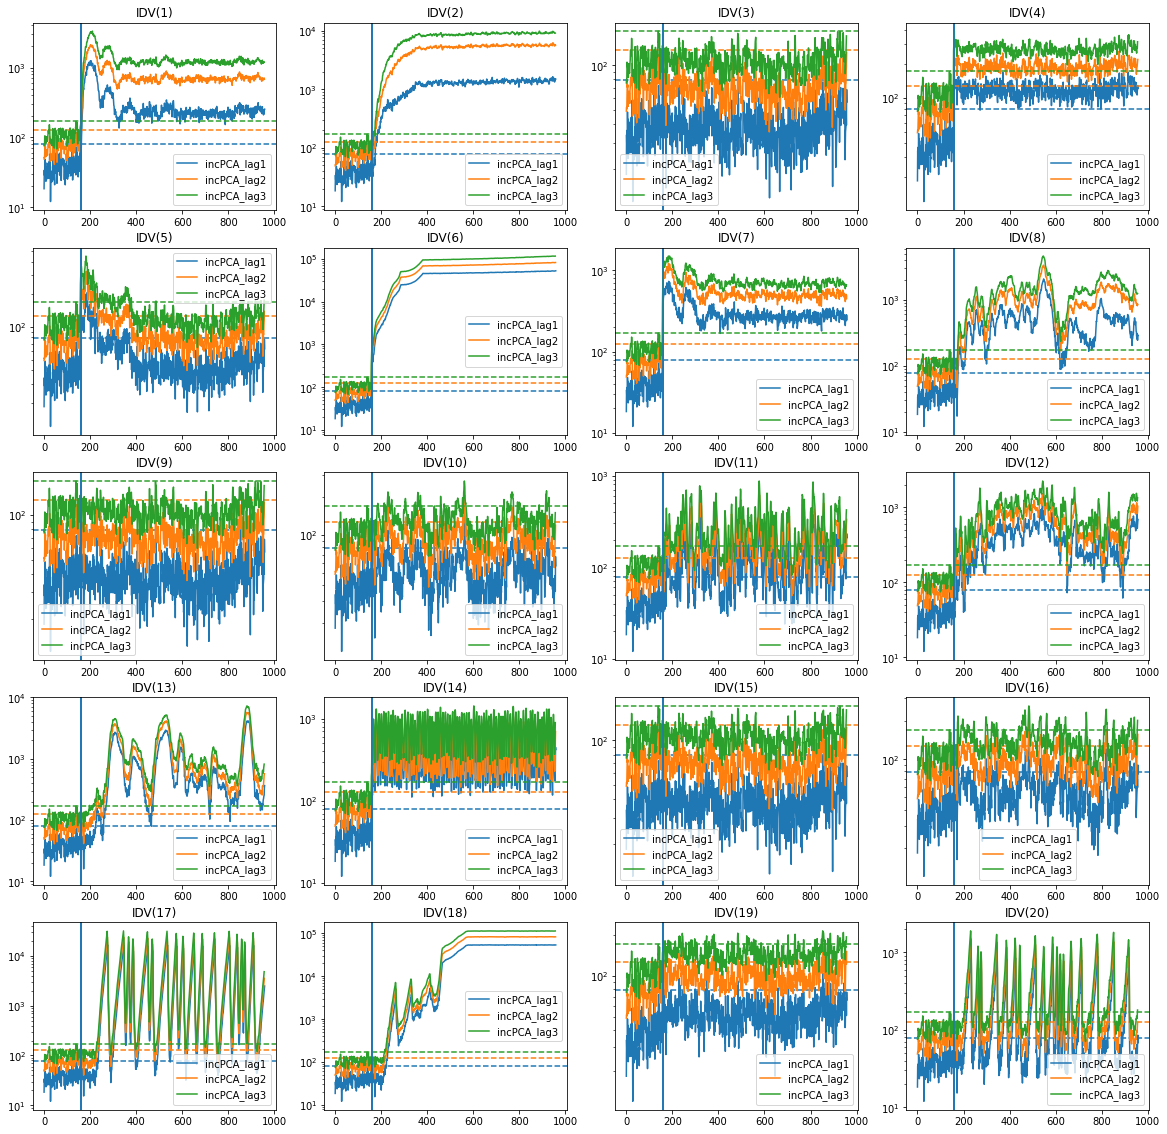

In [22]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'incPCA_lag1': ModelIncPCA(30), 'incPCA_lag2': ModelIncPCA(30), 'incPCA_lag3': ModelIncPCA(30)}
lags = {'incPCA_lag1': 1, 'incPCA_lag2': 2, 'incPCA_lag3': 3}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(apply_lag(df_train,lags[name]))
    spe_validation = model.test(apply_lag(df_validation,lags[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = apply_lag(test_faulty[(test_faulty.faultNumber==i+1) & 
                                        (test_faulty.simulationRun==1)].iloc[:,3:], lags[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [23]:
# fdr_df.to_csv('./experimental_result_csv/ipcalag.csv')

## Filter noise

WS_10     65.53125
WS_50     61.75625
WS_100    58.11875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,99.250,98.125,0.750,99.625,99.500,99.875,99.875,97.625,0.750,23.750,77.75,98.625,93.625,40.0,0.75,29.875,91.000,93.000,1.000,65.875
WS_50,98.750,97.125,1.000,98.500,99.000,99.500,99.375,96.750,1.625,17.250,56.50,89.375,92.125,2.0,0.25,9.875,90.375,92.000,0.500,93.250
WS_100,98.375,96.375,1.875,96.375,98.625,99.375,98.625,92.625,1.375,5.125,19.75,86.500,90.000,0.0,0.00,1.750,90.125,91.125,1.875,92.500


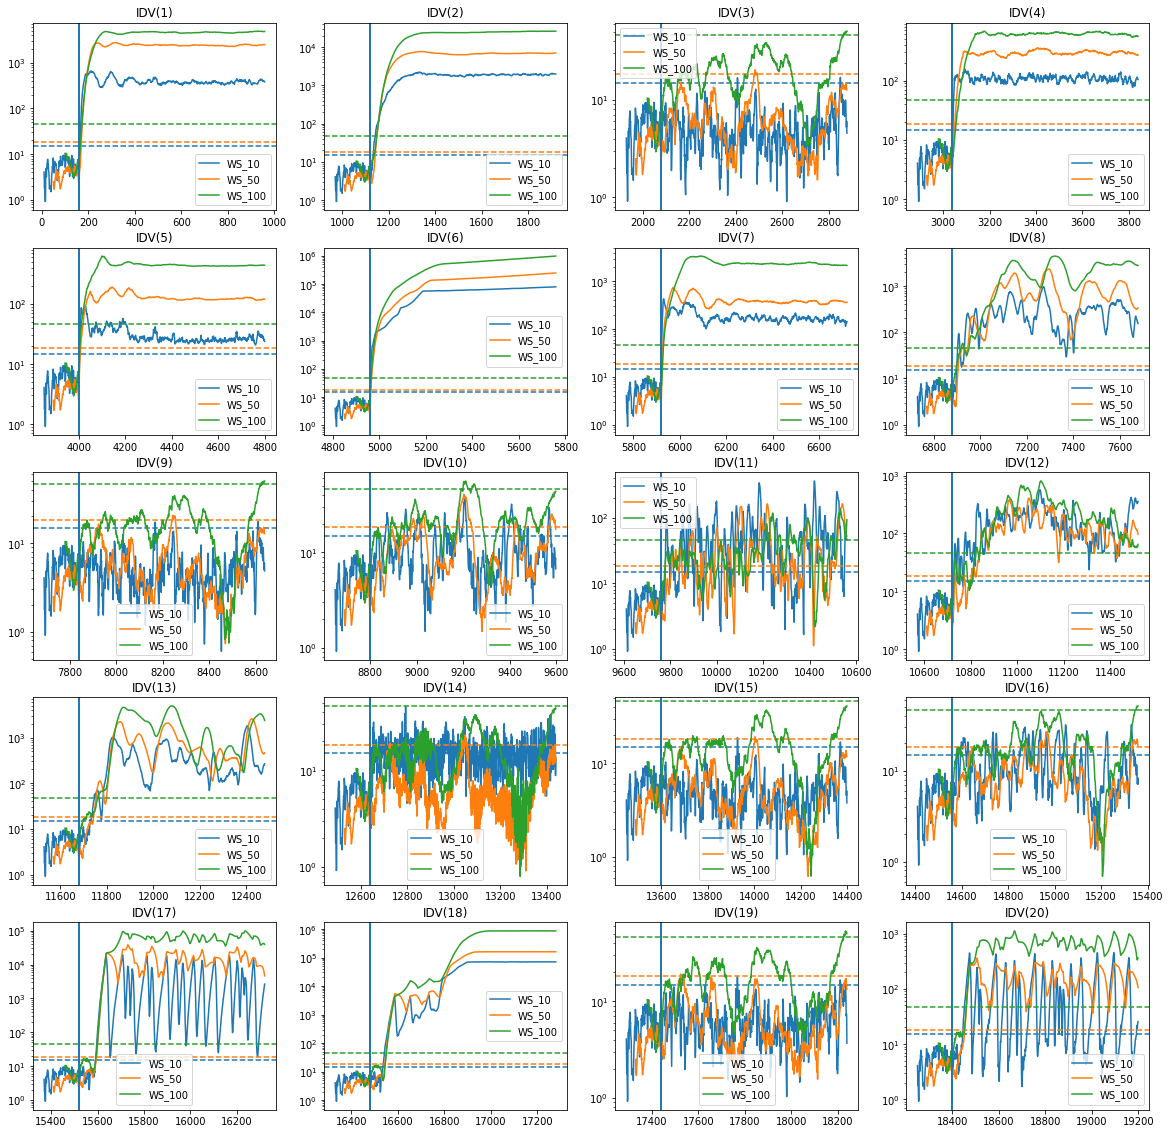

In [24]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelIncPCA(30), 'WS_50': ModelIncPCA(30), 'WS_100': ModelIncPCA(30)}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [25]:
# fdr_df.to_csv('./experimental_result_csv/ipcanf.csv')